### LSTM-RNN Sumatera Selatan Percobaan 3
- Titik Panas diperngaruhi oleh ENSO

In [1]:
# library manipulation dataset
import pandas as pd
from pandas import concat
from pandas import DataFrame
from pandas import read_csv
from pandas import read_excel

# library manipulation array
import numpy as np
from numpy import concatenate
from numpy import array

# library configuration date and time
import time
from datetime import datetime

# library data visualization
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import pyplot
from matplotlib import pyplot as plt

# library analysis acf and pacf
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

# library normalize data with max-min algorithm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

# library algorithm lstm-rnn with keras
import tensorflow as tf
from tensorflow.keras import models
from keras.models import Sequential
from keras.layers import RNN
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.optimizers import Adam, Adamax, RMSprop, SGD
from keras.layers import LeakyReLU

# Early stoping
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# library evaluation model
from math import sqrt
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
# Set waktu komputasi
start = time.time()

In [3]:
# fix random seed for reproducibility
np.random.seed(1234)

In [4]:
# membaca dataset
dataset = read_excel("dataset/dataset.xlsx")

In [5]:
# set index tanggal
dataset = dataset.set_index("tanggal")

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 2001-01-31 to 2020-12-31
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sst             240 non-null    float64
 1   soi             240 non-null    float64
 2   oni             240 non-null    float64
 3   curah_hujan     240 non-null    float64
 4   hotspot_sumsel  240 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 11.2 KB


In [7]:
print(dataset.head())

             sst  soi   oni  curah_hujan  hotspot_sumsel
tanggal                                                 
2001-01-31 -0.76  1.0 -0.68   418.600006               3
2001-02-28 -0.56  1.7 -0.52   295.399994               5
2001-03-31 -0.37  0.9 -0.44   360.600006              10
2001-04-30 -0.56  0.2 -0.34   403.700012              20
2001-05-31 -0.46 -0.5 -0.25   116.900002              39


### Studi Kasus Sumatera Selatan

In [8]:
# memilih area studi
df_sumsel = dataset[["hotspot_sumsel", "sst", "soi"]]
df_sumsel.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 2001-01-31 to 2020-12-31
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   hotspot_sumsel  240 non-null    int64  
 1   sst             240 non-null    float64
 2   soi             240 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 7.5 KB


In [9]:
print(df_sumsel.head())

            hotspot_sumsel   sst  soi
tanggal                              
2001-01-31               3 -0.76  1.0
2001-02-28               5 -0.56  1.7
2001-03-31              10 -0.37  0.9
2001-04-30              20 -0.56  0.2
2001-05-31              39 -0.46 -0.5


In [10]:
# ensure all data is float
values = df_sumsel.values
values = values.astype('float64')

### Normalisasi Data

In [11]:
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

In [12]:
np.round(scaled[:5],6)

array([[-0.999723, -0.614849,  0.366667],
       [-0.999445, -0.522042,  0.6     ],
       [-0.998751, -0.433875,  0.333333],
       [-0.997364, -0.522042,  0.1     ],
       [-0.994728, -0.475638, -0.133333]])

### Supervised Learning

In [13]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    # return value
    return agg

In [14]:
# supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [15]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
1,-0.999723,-0.614849,0.366667,-0.999445,-0.522042,0.600000
2,-0.999445,-0.522042,0.600000,-0.998751,-0.433875,0.333333
3,-0.998751,-0.433875,0.333333,-0.997364,-0.522042,0.100000
4,-0.997364,-0.522042,0.100000,-0.994728,-0.475638,-0.133333
5,-0.994728,-0.475638,-0.133333,-0.999029,-0.336427,0.133333


In [16]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)

In [17]:
values = reframed.values

In [18]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var1(t)
1,-0.999723,-0.614849,0.366667,-0.999445
2,-0.999445,-0.522042,0.600000,-0.998751
3,-0.998751,-0.433875,0.333333,-0.997364
4,-0.997364,-0.522042,0.100000,-0.994728
5,-0.994728,-0.475638,-0.133333,-0.999029


### Data latih dan Data Uji

In [19]:
# split into train and test sets
train_size = int(len(values) * 0.8)
test_size = len(values) - train_size
train, test = values[0:train_size,:], values[train_size:len(values),:]

In [20]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

- Check data train, for result supervised learning

In [21]:
temp_train_X = pd.DataFrame(train_X)
temp_train_y = pd.DataFrame(train_y)

In [22]:
hasil = pd.concat([temp_train_X, temp_train_y], axis=1)
hasil.head()

,0,1,2,0
0,-0.999723,-0.614849,0.366667,-0.999445
1,-0.999445,-0.522042,0.600000,-0.998751
2,-0.998751,-0.433875,0.333333,-0.997364
3,-0.997364,-0.522042,0.100000,-0.994728
4,-0.994728,-0.475638,-0.133333,-0.999029


- Check data test, for result supervised learning

In [23]:
temp_test_X = pd.DataFrame(test_X)
temp_test_y = pd.DataFrame(test_y)

In [24]:
hasil = pd.concat([temp_test_X, temp_test_y], axis=1)
hasil.head()

,0,1,2,0
0,-0.999168,-0.415313,1.333333e-01,-0.998474
1,-0.998474,-0.382831,1.000000e-01,-0.999723
2,-0.999723,-0.215777,-1.179612e-16,-0.997503
3,-0.997503,-0.164733,3.333333e-01,-0.997364
4,-0.997364,-0.095128,-3.333333e-02,-0.994450


- reshape input for samples, time steps, features

In [25]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [26]:
print(train_X.shape, train_y.shape)

(191, 1, 3) (191,)


In [27]:
print(test_X.shape, test_y.shape)

(48, 1, 3) (48,)


### Model Prediksi LSTM-RNN

In [28]:
# design network grid serach
model = Sequential()

# First LSTM layer with Dropout regularisation
model.add(
    LSTM(
        units=10,
        activation='elu',
        input_shape=(train_X.shape[1], train_X.shape[2])
    )
)
model.add(Dropout(0.15))

# The output layer
model.add(Dense(1))

# Compiling model the LSTM-RNN
model.compile(
    optimizer='rmsprop',
    loss='mae',
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.MeanSquaredError(),
        tf.keras.metrics.RootMeanSquaredError()
    ]
)

In [29]:
# fit network
history = model.fit(train_X, train_y, epochs=2000, batch_size=16,
                    validation_data=(test_X, test_y),
                    verbose=0, shuffle=False)

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                560       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


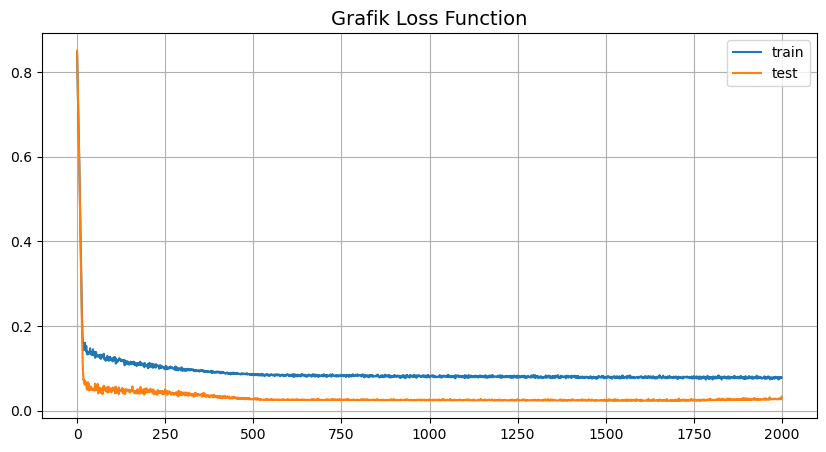

In [31]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(history.history['loss'], color="tab:blue", label="train", linewidth=1.5)
ax.plot(history.history['val_loss'], color="tab:orange", label="test", linewidth=1.5)

# membuat label-label
ax.set_title("Grafik Loss Function", fontsize=14)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()

In [32]:
# 5. make predictions
predictions = model.predict(test_X, verbose=0)
print(predictions[:, 0])

[-0.98863137 -0.9874198  -0.98598224 -0.9883689  -0.9818949  -0.98236096
 -0.97377926 -0.981269   -0.97289246 -0.9656505  -0.98614985 -0.99171555
 -0.9905273  -0.9907518  -0.99059004 -0.9927926  -0.98756295 -0.98476905
 -0.9820239  -0.96900564 -0.9559489  -0.90233225 -0.95654994 -0.98053753
 -0.9941365  -0.98436624 -0.9775634  -0.98225677 -0.9839115  -0.97109663
 -0.9754317  -0.9648483  -0.8875386  -0.35493076 -0.61947364 -0.69216824
 -0.97536117 -0.9833219  -0.9818422  -0.9765627  -0.97925407 -0.9859692
 -0.98475885 -0.98543847 -0.98761487 -0.9896407  -0.99075323 -0.9928232 ]


### Evaluasi Model LSTM-RNN

In [33]:
scores = model.evaluate(train_X, train_y)
scores

6/6 [==============================] - 0s 2ms/step - loss: 0.0780 - mean_absolute_error: 0.0780 - mean_squared_error: 0.0448 - root_mean_squared_error: 0.2116


[0.0779871717095375,
 0.0779871717095375,
 0.044780366122722626,
 0.2116137146949768]

In [34]:
scores = model.evaluate(test_X, test_y)
scores

2/2 [==============================] - 0s 3ms/step - loss: 0.0327 - mean_absolute_error: 0.0327 - mean_squared_error: 0.0068 - root_mean_squared_error: 0.0824


[0.032676152884960175,
 0.032676152884960175,
 0.006797419860959053,
 0.08244646340608597]

- MAE

In [35]:
mae = mean_absolute_error(test_y, predictions)
print('Test MAE: %.4f' % mae)

Test MAE: 0.0327


- MSE

In [36]:
mse = mean_squared_error(test_y, predictions)
print('Test MSE: %.4f' % mse)

Test MSE: 0.0068


- RMSE

In [37]:
# calculate RMSE
rmse = sqrt(mean_squared_error(test_y , predictions))
print('Test RMSE: %.4f' % rmse)

Test RMSE: 0.0824


- korelasi dan signifikansi

In [38]:
hasil = np.stack((test_y.reshape(-1),predictions.reshape(-1)),axis=1)
hasil = pd.DataFrame(hasil, columns = ['data_aktual','prediksi'])
hasil.head()

,data_aktual,prediksi
0,-0.998474,-0.988631
1,-0.999723,-0.987420
2,-0.997503,-0.985982
3,-0.997364,-0.988369
4,-0.994450,-0.981895


In [39]:
import scipy.stats as sc
r, p = sc.pearsonr(hasil["data_aktual"], hasil["prediksi"])
print("korelasi data akual dengan hasil prediksi" +" {:.4f} ".format(r)+ "dengan signifikansi" +" {:.4f} ".format(p))

korelasi data akual dengan hasil prediksi 0.7300 dengan signifikansi 0.0000 


- Waktu komputasi

In [40]:
# Set akhir waktu komputasi 
end = time.time()

In [41]:
# Proses menghitung waktu komputasi
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)

In [42]:
# Hasil waktu komputasi
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

00:01:33.45


### Visualisasi hasil prediksi

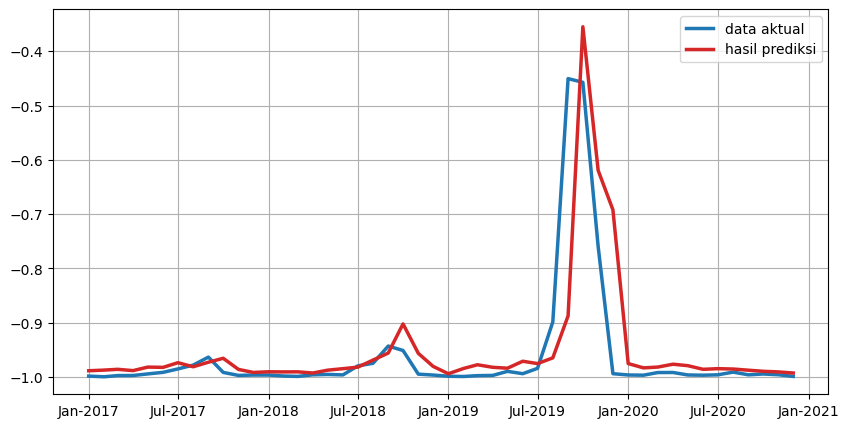

In [43]:
# generate urutan data sesuai panjang datanya
x = pd.date_range(start="2017-01-01", periods=len(test_y), freq='MS')

# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(x, test_y, color="tab:blue", label="data aktual", linewidth=2.5)
ax.plot(x, predictions, color="tab:red", label="hasil prediksi", linewidth=2.5)

# membuat label-label
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()

### 9. Inverse Transform

In [44]:
df_sumsel = np.array(dataset["hotspot_sumsel"])

In [45]:
scaler = MinMaxScaler(feature_range=(-1,1))
df_sumsel = scaler.fit_transform(df_sumsel.reshape(-1,1))

In [46]:
# inverse value test predictions
testPredictions = scaler.inverse_transform(predictions)
testActual = scaler.inverse_transform(np.array(test_y).reshape(-1, 1))

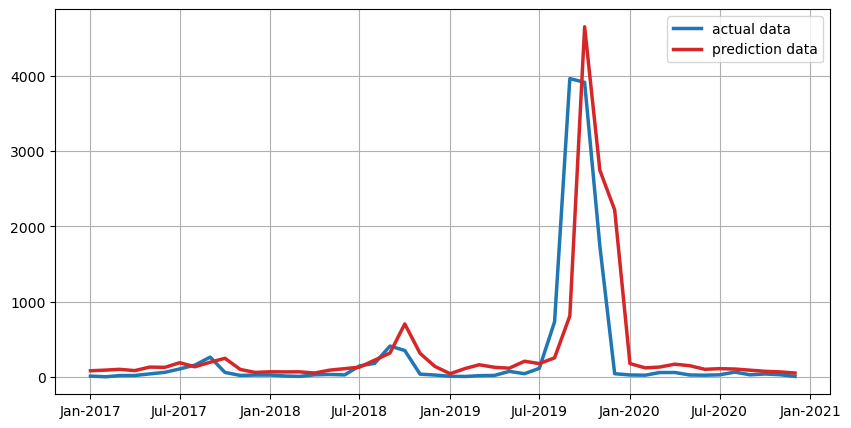

In [47]:
# generate urutan data sesuai panjang datanya
x = pd.date_range(start="2017-01-01", periods=len(test_y), freq='MS')

# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(x, testActual, color="tab:blue", label="actual data", linewidth=2.5)
ax.plot(x, testPredictions, color="tab:red", label="prediction data", linewidth=2.5)

# membuat label-label
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.legend(loc="best")
ax.grid(True)

# menampilkan plot
plt.show()

In [48]:
#  shift test predictions for plotting
testPredictionsPlot = np.empty_like(df_sumsel)
testPredictionsPlot[:, :] = np.nan
testPredictionsPlot[(len(dataset) - testPredictions.shape[0]):len(dataset), :] = testPredictions

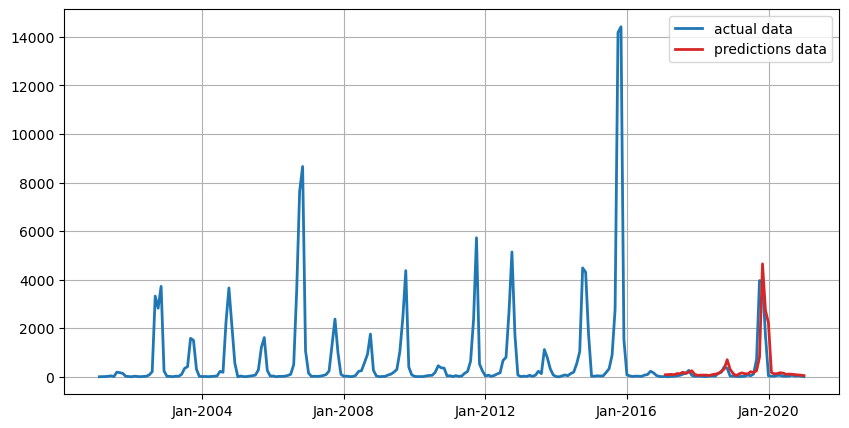

In [49]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(dataset.index.values, scaler.inverse_transform(df_sumsel), color="tab:blue", label="actual data", linewidth=2)
ax.plot(dataset.index.values, testPredictionsPlot, color="tab:red", label="predictions data", linewidth=2)

# membuat label-label
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.legend(loc="best")
ax.grid(True)

# menampilkan plot
plt.show()